#LAB. 3
#Homework 3: Mining Data Streams

In the following homework, **TRIEST-BASE** and **TRIEST-IMP**, two algorithms for graph triangle estimation with fixed memory, are implemented accordingly with the pseudo-code in the paper.

https://www.kdd.org/kdd2016/papers/files/rfp0465-de-stefaniA.pdf

**Additional Questions:**

1) *What were the challenges you faced when implementing the algorithm?*

As the documentation was great, implementing the algorithm has not been hard as it would have been from a paper without pseudo code. Still some thought on the supporting data structures like an adjacency list was necessary to speed up the execution.

2) *Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.*

Counting operations are blocking and rely on the current state of the sample set, so there is no parallelization capability in that direction. As our implementation keeps the neighbours in the adjacency list, parallelizing the computation of neighbours is not really necessary here.

3) *Does the algorithm work for unbounded graph streams? Explain.*

Yes, the algorithm doesn't rely on any bound, the estimation only takes into account the current counters and the current sample set. It could be implemented swapping the *for* loop iterating over the edges with one iterating over an incoming input from a stream and deciding when to output the current estimation.

4) *Does the algorithm support edge deletions? If not, what modification would it need? Explain.*

The Fully Dynamic algorithm is required. Random Pairing tracks the number of edges deleted from the sample set due to deletion in the stream. This information then drives the insertion of a new edge in the sample set and the estimation of the number of triangles.

#Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import gzip
import pandas as pd
import numpy as np
import os
import sys
import time
import argparse
import random
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
sys.path.append('/content/drive/MyDrive/DM_Labs/dataset')

import pandas as pd
import numpy as np

Mounted at /content/drive


In [ ]:
#read gzip on drive

#Local:

In [195]:
import gzip
import pandas as pd
import numpy as np
import os
import sys
import time
import argparse
import random
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
random.seed(42)

First, the file is going to be read eliminating self loops if any.

In [196]:
filepath = 'Downloads/facebook_combined.txt.gz'

def read_dataset(filepath):
    with gzip.open(filepath) as file:

      for line in file:
        line = line.decode('utf-8')
        nodes = line.split()
        
        source, dest = int(nodes[0]), int(nodes[1])

        if source == dest:
          # Disabling self loops
          continue

        yield source, dest

In [218]:
dataset = read_dataset(filepath)

# Triest-Base

In [226]:
def triest_base(M, graph):

  counter = 0
  loc_counters = defaultdict(int)
  t = 0
  edges = set()
  adjacency_list = defaultdict(set)
  
  def update(x, src, dst, neighbours):
    nonlocal counter
    nonlocal loc_counters

    for n in neighbours:
      counter = counter + x
      loc_counters[n] = loc_counters[n] + x
      loc_counters[src] = loc_counters[src] + x
      loc_counters[dst] = loc_counters[dst] + x
          
    # Clean up of the empty entries
    if x == -1:
      for n in itertools.chain(neighbours, (src, dst)):
        if not loc_counters[n]: del loc_counters[n]
          
  
  def sample(t): # SampleEdge((u, v), t) in the paper
    nonlocal M
    nonlocal edges
    nonlocal adjacency_list

    if t <= M:
      return True
      
    if random.random() < M/t:
      list_edges = list(edges)

      index = random.choice(range(len(list_edges))) # Takes a random edge to remove
      src, dst = list_edges[index]
      
      # Remove edge from the edge set and adjacency_list S <- S \ {(u, v)}
      edges.remove((src, dst))
      adjacency_list[src].remove(dst)
      adjacency_list[dst].remove(src)
      if not adjacency_list[src]: del adjacency_list[src]
      if not adjacency_list[dst]: del adjacency_list[dst]
          
      # UpdateCounters (-, (u, v))
      if src not in adjacency_list or dst not in adjacency_list:
        return True
      # Compute intersection
      intersection = adjacency_list.get(src) & adjacency_list.get(dst)
      update(-1, src, dst, intersection)
      return True
    
    return False
          
      
  for src, dst in graph:
    if (src, dst) in edges: # Check if the edge is already present
      continue
      
    t = t + 1 # Update
      
    if sample(t):
      adjacency_list[src].add(dst)
      adjacency_list[dst].add(src)
      edges.add((src, dst))
      # UpdateCounters (+, (u, v))
      if src not in adjacency_list or dst not in adjacency_list:
        continue
      # Compute intersection
      intersection = adjacency_list.get(src) & adjacency_list.get(dst)
      update(1, src, dst, intersection)
  
  # Estimation
  eta = max(1, t*(t-1)*(t-2) / (M*(M-1)*(M-2)))
  triangles = int(eta * counter)
  print(f'For M = {M}, Triest-Base estimates {triangles} triangles.')
  return triangles

In [227]:
%%time

REAL_TRIANGLES = 1612010
M = [1000, 2000, 5000, 10000, 20000, 50000, 100000]
triangle_estimation = {}

for m_value in M:
  dataset = read_dataset(filepath)
  estimated = triest_base(m_value, dataset)
  triangle_estimation[m_value] = estimated

For M = 1000, Triest-Base estimates 688964 triangles.
For M = 2000, Triest-Base estimates 1805818 triangles.
For M = 5000, Triest-Base estimates 1677040 triangles.
For M = 10000, Triest-Base estimates 1585152 triangles.
For M = 20000, Triest-Base estimates 1557863 triangles.
For M = 50000, Triest-Base estimates 1620861 triangles.
For M = 100000, Triest-Base estimates 1612010 triangles.
Wall time: 1min 17s


In [228]:
triangle_estimation

{1000: 688964,
 2000: 1805818,
 5000: 1677040,
 10000: 1585152,
 20000: 1557863,
 50000: 1620861,
 100000: 1612010}

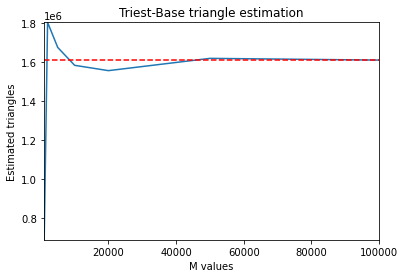

In [233]:
plt.title('Triest-Base triangle estimation')
plt.xlabel('M values')
plt.ylabel('Estimated triangles')
plt.plot(triangle_estimation.keys(), triangle_estimation.values())
plt.axhline(y=REAL_TRIANGLES, color='r', linestyle='--')
plt.axis([1000, 100000, min(triangle_estimation.values()), max(triangle_estimation.values())])
plt.show()

Magnitude of all the deltas is in the 100 thousands:

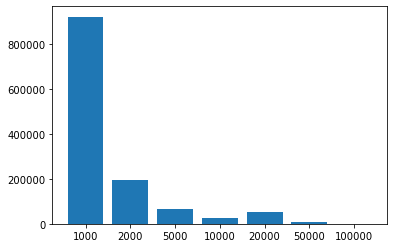

In [271]:
m_to_delta = {}
for m_value in triangle_estimation.keys():
  m_to_delta[m_value] = np.abs(int(triangle_estimation[m_value]) - REAL_TRIANGLES)

plt.bar(range(len(m_to_delta)), list(m_to_delta.values()), align='center')
plt.xticks(range(len(m_to_delta)), list(m_to_delta.keys()))
plt.show()

# Triest-Improved

In [234]:
def triest_improved(M, graph):

  counter = 0
  loc_counters = defaultdict(int)
  t = 0
  edges = set()
  adjacency_list = defaultdict(set)
  
  def update(t, src, dst, neighbours):
    nonlocal counter
    nonlocal loc_counters
    nonlocal M

    x = max(1, (t-1)*(t-2) / (M*(M-1)))

    for n in neighbours:
      counter = counter + x
      loc_counters[n] = loc_counters[n] + x
      loc_counters[src] = loc_counters[src] + x
      loc_counters[dst] = loc_counters[dst] + x

  
  def sample(t): # SampleEdge((u, v), t) in the paper
    nonlocal M
    nonlocal edges
    nonlocal adjacency_list

    if t <= M:
      return True
      
    if random.random() < M/t:
      list_edges = list(edges)

      index = random.choice(range(len(list_edges))) # Takes a random edge to remove
      src, dst = list_edges[index]
      
      # Remove edge from the edge set and adjacency_list S <- S \ {(u, v)}
      edges.remove((src, dst))
      adjacency_list[src].remove(dst)
      adjacency_list[dst].remove(src)
      if not adjacency_list[src]: del adjacency_list[src]
      if not adjacency_list[dst]: del adjacency_list[dst]
      return True

    return False
          
      
  for src, dst in graph:
    if (src, dst) in edges: # Check if the edge is already present
      continue
      
    t = t + 1 # Update
    
    # Perform update unconditionally # (Improved version)
    if src in adjacency_list and dst in adjacency_list:
        
      # Compute intersection
      intersection = adjacency_list.get(src) & adjacency_list.get(dst)

      update(t, src, dst, intersection) # <-------

    if sample(t):
      adjacency_list[src].add(dst)
      adjacency_list[dst].add(src)
      edges.add((src, dst))
  
  # Estimation
  triangles = int(counter)
  print(f'For M = {M}, Triest-Improved estimates {triangles} triangles.')
  return triangles

In [235]:
%%time

REAL_TRIANGLES = 1612010
M = [1000, 2000, 5000, 10000, 20000, 50000, 100000]
triangle_estimation_improved = {}

for m_value in M:
  dataset = read_dataset(filepath)
  estimated = triest_improved(m_value, dataset)
  triangle_estimation_improved[m_value] = estimated

For M = 1000, Triest-Improved estimates 1619271 triangles.
For M = 2000, Triest-Improved estimates 1545340 triangles.
For M = 5000, Triest-Improved estimates 1648790 triangles.
For M = 10000, Triest-Improved estimates 1627896 triangles.
For M = 20000, Triest-Improved estimates 1591214 triangles.
For M = 50000, Triest-Improved estimates 1619117 triangles.
For M = 100000, Triest-Improved estimates 1612010 triangles.
Wall time: 52.8 s


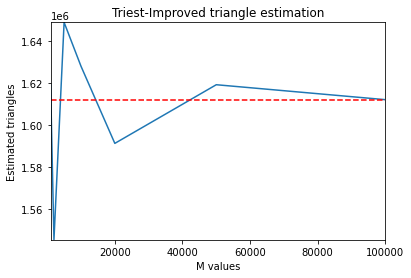

In [236]:
plt.title('Triest-Improved triangle estimation')
plt.xlabel('M values')
plt.ylabel('Estimated triangles')
plt.plot(triangle_estimation_improved.keys(), triangle_estimation_improved.values())
plt.axhline(y=REAL_TRIANGLES, color='r', linestyle='--')
plt.axis([1000, 100000, min(triangle_estimation_improved.values()), max(triangle_estimation_improved.values())])
plt.show()

As can be observed from the plot, the values of estimations are much closer. Let's have a better look:

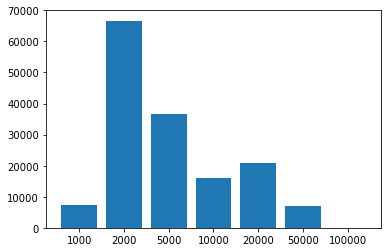

In [270]:
m_to_delta_improved = {}
for m_value in triangle_estimation_improved.keys():
  m_to_delta_improved[m_value] = np.abs(int(triangle_estimation_improved[m_value]) - REAL_TRIANGLES)

plt.bar(range(len(m_to_delta_improved)), list(m_to_delta_improved.values()), align='center')
plt.xticks(range(len(m_to_delta_improved)), list(m_to_delta_improved.keys()))
plt.show()

# To HTML

In [4]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/DM_Labs/Lab3.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/DM_Labs/Lab3.ipynb to html
[NbConvertApp] Writing 370545 bytes to /content/drive/MyDrive/DM_Labs/Lab3.html
